# Data science tools for model selection and evaluation

Data is available in unprecedented amounts, and the field of "Data Science" has grown from a fusion of Statistics, Computer Science, Physics, and many more. Concurrently, analysis capability is also increasing and is being made available to anyone with a laptop through open source initiatives e.g. using Python. This is a very exciting development for Earth Science as a field, but should be applied with care to validate the robustness of applications.

In this hands-on tutorial, we will explore concepts related to "unsupervised" machine learning. We will explore structures within synthetic data so that we know the answers we want the "machine" to find! The lecture is outlined as follows:

1. K-means as an unsupervised data exploration tool
2. Using Information Criteria to inform parameter choices 
3. Appreciating and accounting for underlying assumptions


## By the end of this tutorial you should be able to:

- Apply k-means to data, varying the number of parameters 'k'
- Assess the fit of the chosen k-means model using information criteria
- Understand what changing parameters does for k-means models
- Appreciate the importance of critical model evaluation


*Additional reading:*

- Annalyn Ng's "Numsense! Data Science for the Layman: No Math Added"

- Joel Grus' "Data Science from Scratch: First Principles with Python"



## 1. K-means as an unsupervised data exploration tool


Unsupervised learning techniques are a great way to explore data, even if you may not know the underlying structure. There are many algorithms available, and here we use k-means as our exploratory tool. 

### K-means assumptions to be aware of:

With every clustering algorithm come assumptions about the data. These assumptions refer to the structures that determine how different data variables interact with one another. These interactions produce different "shapes". For data that are "round" (also refered to as "Gaussian"), k-means is a good starting point.

The k-means algorithm is based on underlying mathematics that allows it to partition the area and identify clusters$^1$. The way it does this is by effectively drawing straight lines in 2 dimensions (or hyperplanes in higher dimensions). It follows that k-means will poorly identify any structures that cannot be seperated using straight lines. This effectively means that k-means would only do a perfect job if our data are normally distributed; a very strong assumption.

To start, the k-means algorithm makes a stochastic guess at where the clusters are located and assigns each data point to the nearest cluster. This means that cluster locations are initially scattered across the data, and the algorithm iterates to move around the cluster locations until it converges on a solution. This solution is determined by minimizing the objective function $J$:

$$J = \sum^{k}_{j=1} \sum^{n}_{i=1} ||x^{j}_i - c_{j}||^2$$

where $k$ is the number of clusters, $n$ is the number of data points, and $c$ is the place where the "guess" of the cluster location is.


1: Voroni diagrams if you happen to be a math major: http://nms.csail.mit.edu/~aklmiu/6.838/L7.pdf

In [1]:
# We start by loading some handy libraries
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans, DBSCAN
from sklearn import mixture
import seaborn as sns; sns.set()

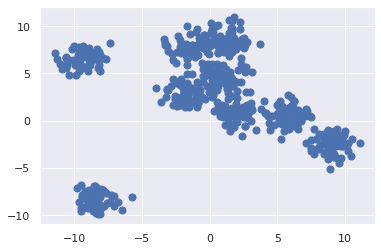

In [2]:
# Set the number of clusters that the algorithm should ideally find
centerSeed = 9

# Make the "blobs" and save the true cluster centers to y_true
X, y_true = make_blobs(n_samples=600, centers=centerSeed,
                       cluster_std=0.9, random_state=0)

# Plot the data
plt.scatter(X[:, 0], X[:, 1], s=50);

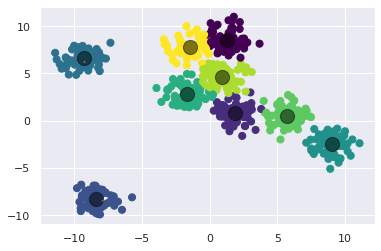

In [3]:
# Apply the k-mean algorithm to our data X
kmeans = KMeans(n_clusters=centerSeed)
kmeans.fit(X)

# Associate each data point to a cluster
y_kmeans = kmeans.predict(X)

# Plot the data again, but color by assigned clusters and indicate the centroids using the black dot
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);


At this point, pretend we know nothing of the above! The cluster data $X$ we generated using make_blobs is unknown to us, and we want to explore it! 

We proceed by estimating the AIC and BIC.

## 2. Using Information Criteria to inform parameter choices 

It is very important to assess if identified structures give us "useful" information, and we can do this applying statistical tools.

In [4]:
repeats = 5 # Remember there is stochasticity involved, so we do 10 repeats to collect some error estimates.
kClusters = 25 # Going up to a high number as each "guess" takes time, but it can be worth it!
data = X

criteriaAIC_BIC = np.zeros((repeats,2,kClusters))
for rep in np.arange(0,repeats):
    for nr in np.arange(1,kClusters):
        n_clusters=nr
        X=data
        model=mixture.GaussianMixture(n_components=n_clusters, init_params='kmeans')
        model.fit(X)
        criteriaAIC_BIC[rep,0,nr]=model.aic(X)
        criteriaAIC_BIC[rep,1,nr]=model.bic(X)

Plotting the results fro the Akaike Information Criteria (AIC) and the Bayesian Information Criteria (BIC) can be very instructive. 

Both should initially decrease. The AIC should ideally asymptote and become a flat line. The BIC may increase at one point, to then also become a flat line.

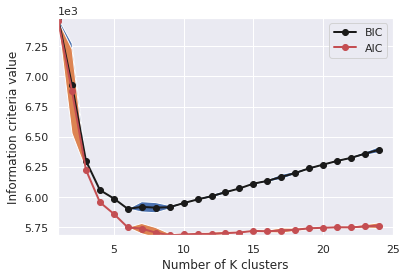

In [5]:
meanAIC = criteriaAIC_BIC[:, 0, 0:kClusters].mean(axis = 0)
stdAIC = criteriaAIC_BIC[:, 0, 0:kClusters].std(axis = 0)

meanBIC = criteriaAIC_BIC[:, 1, 0:kClusters].mean(axis = 0)
stdBIC = criteriaAIC_BIC[:, 1, 0:kClusters].std(axis = 0)

plt.plot(np.arange(0, kClusters),meanBIC, '-ok', label='BIC', linewidth=2)
plt.fill_between(np.arange(0, kClusters), meanBIC-2*stdBIC, meanBIC+2*stdBIC)

plt.plot(np.arange(0, kClusters),meanAIC, '-or', label='AIC', linewidth=2)
plt.fill_between(np.arange(0, kClusters), meanAIC-2*stdAIC, meanAIC+2*stdAIC)

plt.ylim(np.min(meanAIC[5:]), np.max(meanBIC))
plt.xlabel('Number of K clusters')
plt.ylabel('Information criteria value')
plt.legend()
plt.xlim(1,kClusters)
#plt.ylim(5.60e3, 5.78e3)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

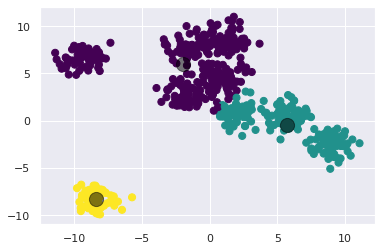

In [6]:
### Replace with your guess!
clusterGuess=3

kmeans = KMeans(n_clusters=clusterGuess)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);


## 3. Real-world applications require an appreciation of for underlying assumptions

Because we mostly have limited or no knowledge of the structures in our data, it is important to be aware of the assumptions our clustering methods make. We need to assess if these assumptions are fair. If we don't take assumptions into account, we may end up with useless or even misleading results!



## 3.1 What if the structures are not "round"?

Unfortunately, most data one encounters are not "round"/Gaussian. Below we'll demonstrate what happens when we have different data distributions, and explore how "wrong" k-means can be.

- Assessing how good the fit is using the AIC and BIC are a good way of assessing if this could be an issue.

## 3.2 What if the stocastic element makes a difference? 

To initialize k-means the algorithm makes a stochastic "guess" as the cluster centers. This means that if we repeat the method, the initial "guess" could be different enough to give us a different answer. 

- Assessing the fit using the AIC and BIC is a good way of checking this issue.

We now make synthetic data that is not round but elongated (anisotropic). The difference in the structure of the data will be used to reveal the shortcomings of a method that operates under the assumptions of k-means.

Different methods operate under different assumptions. We explore density-based spatial clustering of applications with noise (DBSCAN). This algorithm uses the distance between the data points, and a set minimum of points needed to be "significant".

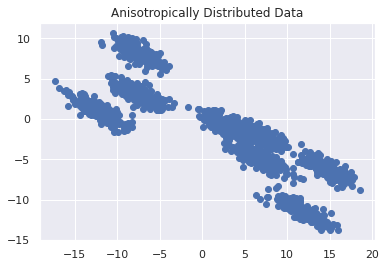

In [12]:
centerSeed = 8
n_samples = 1500
random_state = 170
X, y = make_blobs(n_samples=n_samples, random_state=random_state, centers=centerSeed)

#### Anisotropically distributed data ####
transformation = [[1.60834549, -0.63667341], [-0.40887718, 0.85253229]]
X_aniso = np.dot(X, transformation)

plt.scatter(X_aniso[:, 0], X_aniso[:, 1], cmap='viridis')
plt.title("Anisotropically Distributed Data");

### Using k-means on structures that are not round

Here we demonstrate what k-means does when we explore data that do *not* conform with the model's assumption.

The data is somewhat randomly 'chopped', and fails to find the underlying structures.

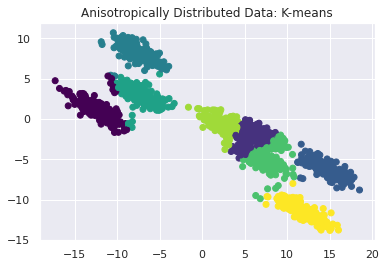

In [13]:
cluster_guess=8

y_pred = KMeans(n_clusters=cluster_guess, random_state=random_state).fit_predict(X_aniso)

plt.scatter(X_aniso[:, 0], X_aniso[:, 1], c=y_pred, cmap='viridis')
plt.title("Anisotropically Distributed Data: K-means");

### Using DBSCAN on structures that are not round

DBSCAN does a much better job at identifying the anisotropic clusters.

The number of clusters DBSCAN found was:  8


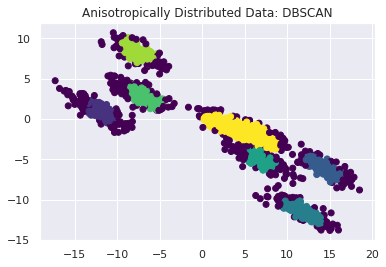

In [14]:
EPS=0.5
MIN_SAMP=12

#Anisotropically distributed data
transformation = [[1.60834549, -0.63667341], [-0.40887718, 0.85253229]]
X_aniso = np.dot(X, transformation)
y_pred = DBSCAN(eps=EPS, min_samples=MIN_SAMP).fit_predict(X_aniso)

print('The number of clusters DBSCAN found was: ', len(np.unique(y_pred)))
plt.scatter(X_aniso[:, 0], X_aniso[:, 1], c=y_pred, cmap='viridis')
plt.title("Anisotropically Distributed Data: DBSCAN");

## Bonus material

We continue to explore visually what happens when the structures we are looking for can and cannot be isolated by k-means and DBSCAN.

Automatically created module for IPython interactive environment


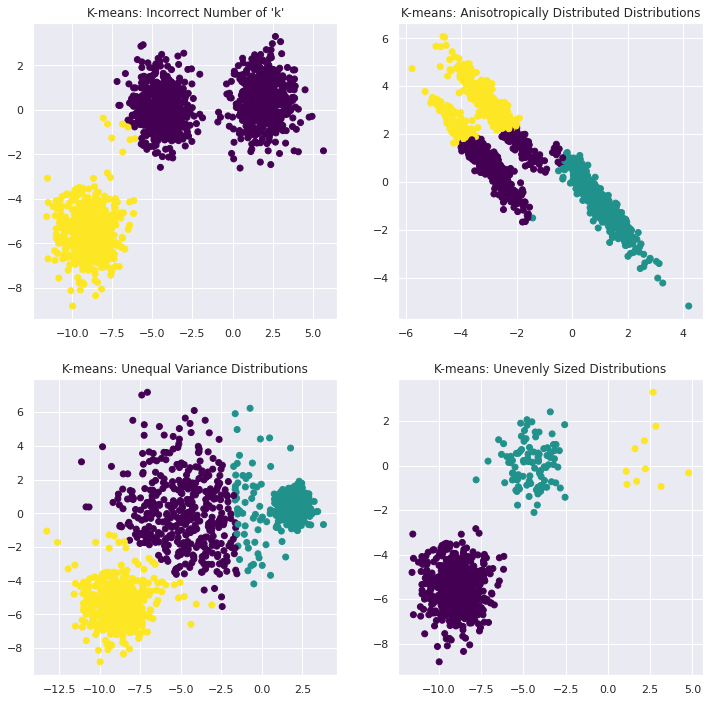

In [15]:
print(__doc__)

# Modofied by <maikejulie@gmail.com> from Phil Roth <mr.phil.roth@gmail.com>
# License: BSD 3 clause

plt.figure(figsize=(12, 12))

n_samples = 1500
random_state = 170
X, y = make_blobs(n_samples=n_samples, random_state=random_state)

#### Incorrect number of clusters ####
y_pred = KMeans(n_clusters=2, random_state=random_state).fit_predict(X)

plt.subplot(221)
plt.scatter(X[:, 0], X[:, 1], c=y_pred, cmap='viridis')
plt.title("K-means: Incorrect Number of 'k'")

#### Anisotropically distributed data ####
transformation = [[0.60834549, -0.63667341], [-0.40887718, 0.85253229]]
X_aniso = np.dot(X, transformation)
y_pred = KMeans(n_clusters=3, random_state=random_state).fit_predict(X_aniso)

plt.subplot(222)
plt.scatter(X_aniso[:, 0], X_aniso[:, 1], c=y_pred, cmap='viridis')
plt.title("K-means: Anisotropically Distributed Distributions")

#### Different variance #####
X_varied, y_varied = make_blobs(n_samples=n_samples,
                                cluster_std=[1.0, 2.5, 0.5],
                                random_state=random_state)
y_pred = KMeans(n_clusters=3, random_state=random_state).fit_predict(X_varied)

plt.subplot(223)
plt.scatter(X_varied[:, 0], X_varied[:, 1], c=y_pred, cmap='viridis')
plt.title("K-means: Unequal Variance Distributions")

##### Unevenly sized blobs ####
X_filtered = np.vstack((X[y == 0][:500], X[y == 1][:100], X[y == 2][:10]))
y_pred = KMeans(n_clusters=3,
                random_state=random_state).fit_predict(X_filtered)

plt.subplot(224)
plt.scatter(X_filtered[:, 0], X_filtered[:, 1], c=y_pred, cmap='viridis')
plt.title("K-means: Unevenly Sized Distributions")

plt.show()

Automatically created module for IPython interactive environment


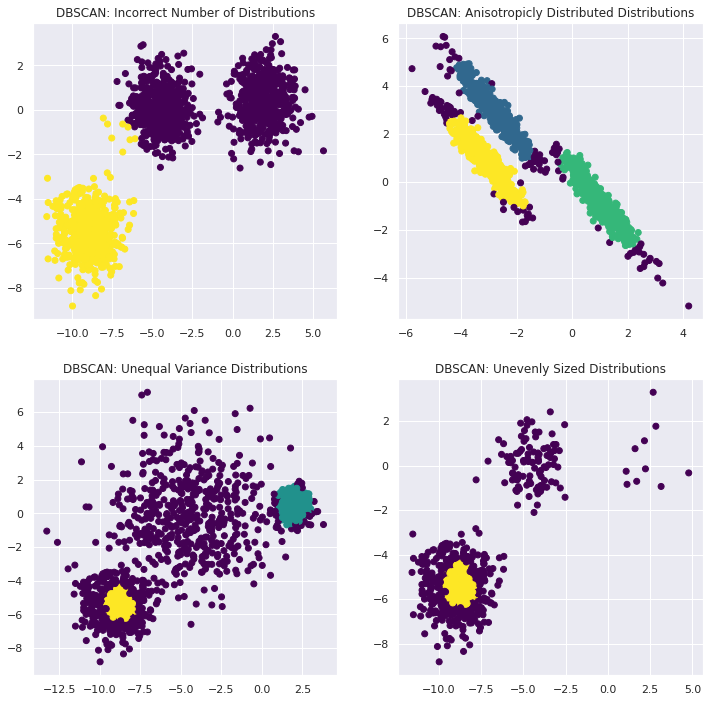

In [11]:
print(__doc__)

EPS=0.3
MIN_SAMP=20

plt.figure(figsize=(12, 12))

n_samples = 1500
random_state = 170
X, y = make_blobs(n_samples=n_samples, random_state=random_state)

# Incorrect number of clusters
y_pred = KMeans(n_clusters=2, random_state=random_state).fit_predict(X)

plt.subplot(221)
plt.scatter(X[:, 0], X[:, 1], c=y_pred, cmap='viridis')
plt.title("DBSCAN: Incorrect Number of Distributions")

# Anisotropicly distributed data
transformation = [[0.60834549, -0.63667341], [-0.40887718, 0.85253229]]
X_aniso = np.dot(X, transformation)
y_pred = DBSCAN(eps=EPS, min_samples=MIN_SAMP).fit_predict(X_aniso)

plt.subplot(222)
plt.scatter(X_aniso[:, 0], X_aniso[:, 1], c=y_pred, cmap='viridis')
plt.title("DBSCAN: Anisotropicly Distributed Distributions")

# Different variance
X_varied, y_varied = make_blobs(n_samples=n_samples,
                                cluster_std=[1.0, 2.5, 0.5],
                                random_state=random_state)
y_pred = DBSCAN(eps=EPS, min_samples=MIN_SAMP).fit_predict(X_varied)

plt.subplot(223)
plt.scatter(X_varied[:, 0], X_varied[:, 1], c=y_pred, cmap='viridis')
plt.title("DBSCAN: Unequal Variance Distributions")

# Unevenly sized blobs
X_filtered = np.vstack((X[y == 0][:500], X[y == 1][:100], X[y == 2][:10]))
y_pred = DBSCAN(eps=EPS, min_samples=MIN_SAMP).fit_predict(X_filtered)

plt.subplot(224)
plt.scatter(X_filtered[:, 0], X_filtered[:, 1], c=y_pred, cmap='viridis')
plt.title("DBSCAN: Unevenly Sized Distributions")

plt.show()

This tutorial is by Maike Sonnewald (github: maikejulie, maikejulie@gmail.com), drawing from Randy Olson (github: rhiever), and Phil Roth <mr.phil.roth@gmail.com>
(License: BSD 3 clause)